In [ ]:
# ------------------------------ Exercise 1 ------------------------------
# I did not get around to seeing what happens when you initialize all 
# weights and biases to zero. Try this and train the neural net. 
# You might think either that 
#     1) the network trains just fine or 
#     2) the network doesn't train at all, but actually it is 
#     3) the network trains but only partially, and achieves a pretty bad 
#        final performance. 
# Inspect the gradients and activations to figure out what is happening 
# and why the network is only partially training, and what part is being 
# trained exactly.

In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
words = open('names.txt', 'r').read().splitlines()

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)

In [7]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []
    for w in words:
        # print(w)

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
    
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])       # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte, Yte = build_dataset(words[n2:])   # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [9]:
# Let's train a deeper network

class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [126]:
n_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator = g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size)
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

47551


In [127]:
with torch.no_grad():
    for layer in layers:
        if isinstance(layer, Linear):
            layer.weight *= 0

In [128]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb, = Xtr[ix], Ytr[ix] # # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_grad
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 1#0.1 if i < 100000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i%10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

      0/ 200000: 3.2958
  10000/ 200000: 3.0271
  20000/ 200000: 2.7633
  30000/ 200000: 2.6101
  40000/ 200000: 2.8132
  50000/ 200000: 2.7690
  60000/ 200000: 2.7750
  70000/ 200000: 2.8423
  80000/ 200000: 2.9841
  90000/ 200000: 2.9989
 100000/ 200000: 2.8870
 110000/ 200000: 2.8799
 120000/ 200000: 2.8669
 130000/ 200000: 2.5848
 140000/ 200000: 2.5401
 150000/ 200000: 2.6086
 160000/ 200000: 3.0590
 170000/ 200000: 2.7276
 180000/ 200000: 2.9195
 190000/ 200000: 2.6891


In [129]:
for layer in layers:
    print(f'Sum of {layer.__class__.__name__} out is {layer.out.sum()}')
    
# We can see that we only have visible updates on the last Linear and last BatchNorm1d layers

Sum of Linear out is 0.0
Sum of BatchNorm1d out is 0.0
Sum of Tanh out is 0.0
Sum of Linear out is 0.0
Sum of BatchNorm1d out is 0.0
Sum of Tanh out is 0.0
Sum of Linear out is 0.0
Sum of BatchNorm1d out is 0.0
Sum of Tanh out is 0.0
Sum of Linear out is 0.0
Sum of BatchNorm1d out is 0.0
Sum of Tanh out is 0.0
Sum of Linear out is 0.0
Sum of BatchNorm1d out is 0.0
Sum of Tanh out is 0.0
Sum of Linear out is 0.08865606784820557
Sum of BatchNorm1d out is 0.002830415964126587


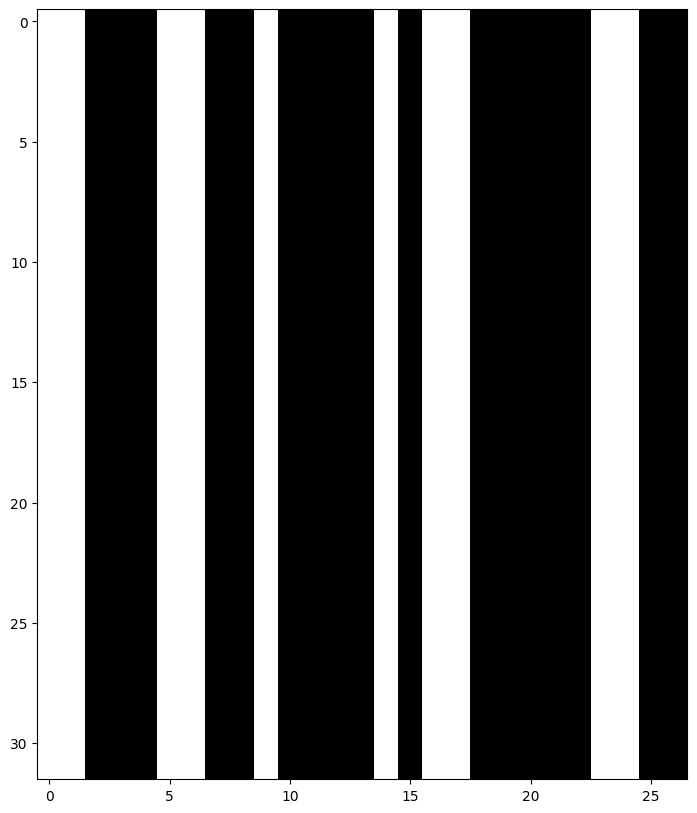

In [130]:
plt.figure(figsize=(20,10))
plt.imshow(layers[-1].out.abs() > 0.99, cmap='gray', interpolation='nearest') # White is true, black is false

# Since we have full white columns, this means that there are dead neurons.

In [2]:
# ------------------------------ Exercise 2 ------------------------------
# BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm 
# etc. has the big advantage that after training, the batchnorm gamma/beta 
# can be "folded into" the weights of the preceeding Linear layers, 
# effectively erasing the need to forward it at test time.
#
# Set up a small 3-layer MLP with batchnorms, train the network, then 
# "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b 
# by creating a new W2, b2 and erasing the batch norm. 
#
# Verify that this gives the same forward pass during inference. i.e. 
# we see that the batchnorm is there just for stabilizing the training, 
# and can be thrown out after training is done! pretty cool.

In [10]:
n_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator = g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(), 
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    # layers[-1].gamma *= 0.1
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

6297


In [11]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb, = Xtr[ix], Ytr[ix] # # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_grad
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i%10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

      0/ 200000: 3.2912
  10000/ 200000: 2.4953
  20000/ 200000: 2.4687
  30000/ 200000: 2.3428
  40000/ 200000: 2.1891
  50000/ 200000: 2.4408
  60000/ 200000: 2.1279
  70000/ 200000: 2.2252
  80000/ 200000: 2.2386
  90000/ 200000: 2.5566
 100000/ 200000: 1.8108
 110000/ 200000: 2.3478
 120000/ 200000: 2.0202
 130000/ 200000: 2.2370
 140000/ 200000: 2.3931
 150000/ 200000: 2.1625
 160000/ 200000: 2.1394
 170000/ 200000: 1.9499
 180000/ 200000: 2.0418
 190000/ 200000: 2.0878


In [12]:
layers[1].training = False

In [253]:
with torch.no_grad():
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    print(loss)

tensor(2.0188)


In [254]:
# now "fold" BatchNorm into Linear somehow :D and get the same loss

In [255]:
import copy
newlayers = copy.deepcopy(layers)
del newlayers[1] # Delete BatchNorm from newlayers

blayer = copy.deepcopy(layers[1]) # Copy of BatchNorm layer

linear = newlayers[0] # variable of Linear layer that preceeded the BatchNorm layer

newlayers

In [256]:
# Checking solution exaplined at https://stackoverflow.com/questions/49536856/tensorflow-how-to-merge-batchnorm-into-convolution-for-faster-inference
# w_new = gamma * w / np.sqrt(var + epsilon)
# b_new = gamma * (b - mean) / np.sqrt(var + epsilon) + beta)

with torch.no_grad():
    linear.weight = blayer.gamma * linear.weight / torch.sqrt(blayer.running_var + blayer.eps)
    linear.bias = blayer.gamma * (linear.bias - blayer.running_mean) / torch.sqrt(blayer.running_var + blayer.eps) + blayer.beta

In [257]:
with torch.no_grad():
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in newlayers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    print(loss)

tensor(2.0188)


In [ ]:
# Both losses are the same and the BatchNorm layer is now removed from newlayers NN